In [18]:
!pip3 install -U numpy matplotlib svgpathtools


Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7504f210>: Failed to establish a new connection: [Errno 111] Connection refused',)': /simple/numpy/
Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7504f2b0>: Failed to establish a new connection: [Errno 111] Connection refused',)': /simple/numpy/
Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7504f330>: Failed to establish a new connection: [Errno 111] Connection refused',)': /simple/numpy/
Retrying (Retry(total=1, connect=None,

In [1]:
import os
import re
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# ============================
# DEMO AREA: 10ft x 10ft
# ============================
DEMO_FT = 10.0
DEMO_CM = DEMO_FT * 30.48  # 304.8 cm

# Margin inside the square so you don't hit the boundary
MARGIN_CM = 10.0

# Motion-friendly grid tuning
GRID_CM = 5.0          # fewer segments, less drift
MAX_STEP_CM = 2.0      # densify within segments
SMOOTH_WINDOW = 3      # light smoothing
SOFT_SNAP_CM = 2.5     # set None if you want sharper corners

# <path> sampling density if SVG contains <path>
SAMPLES_PER_UNIT = 2.0

# Ignore white strokes (often used for background or guides)
IGNORE_WHITE_STROKES = True


In [2]:
svgs = sorted([f for f in os.listdir(".") if f.lower().endswith(".svg")])

print("SVG files in this notebook folder:")
for f in svgs:
    print(" -", f)

if not svgs:
    print("\nNo SVG files found.")
    print("Upload your SVG via the Jupyter file browser Upload button,")
    print("or copy it here with scp, then rerun this cell.")


SVG files in this notebook folder:
 - parking-svgrepo-com.svg
 - road-highway-svgrepo-com.svg
 - svgviewer-output.svg


In [3]:
SVG_FILENAME = input("Type the SVG filename exactly (e.g., parking_lot.svg): ").strip()

with open(SVG_FILENAME, "rb") as f:
    uploaded_bytes = f.read()

svg_filename = SVG_FILENAME
print("Loaded:", svg_filename, "| bytes:", len(uploaded_bytes))


Loaded: svgviewer-output.svg | bytes: 1168


In [4]:
def svg_bytes_to_normalized_polylines_svg_units(
    uploaded_bytes: bytes,
    samples_per_unit: float = 2.0,
    ignore_white_strokes: bool = True,
):
    # Optional <path> support
    try:
        from svgpathtools import parse_path
        have_svgpathtools = True
    except Exception:
        have_svgpathtools = False

    def _strip_ns(tag: str) -> str:
        return tag.split("}", 1)[-1] if "}" in tag else tag

    def _get_float(el, key, default=0.0):
        v = el.get(key)
        if v is None:
            return float(default)
        return float(re.sub(r"[^\d\.\-eE+]", "", v))

    def _parse_points(points_str: str):
        points_str = (points_str or "").strip()
        if not points_str:
            return np.zeros((0, 2), dtype=float)
        nums = re.split(r"[,\s]+", points_str)
        nums = [n for n in nums if n != ""]
        vals = list(map(float, nums))
        return np.array(list(zip(vals[0::2], vals[1::2])), dtype=float)

    def _stroke_is_drawable(el):
        stroke = (el.get("stroke") or "").strip().lower()
        if stroke in ("", "none"):
            return False
        if ignore_white_strokes and stroke in ("white", "#fff", "#ffffff", "rgb(255,255,255)"):
            return False
        return True

    root = ET.fromstring(uploaded_bytes)
    raw = []

    for el in root.iter():
        tag = _strip_ns(el.tag)

        if tag == "line" and _stroke_is_drawable(el):
            x1 = _get_float(el, "x1"); y1 = _get_float(el, "y1")
            x2 = _get_float(el, "x2"); y2 = _get_float(el, "y2")
            raw.append(np.array([[x1, y1], [x2, y2]], dtype=float))

        elif tag == "rect" and _stroke_is_drawable(el):
            x = _get_float(el, "x"); y = _get_float(el, "y")
            w = _get_float(el, "width"); h = _get_float(el, "height")
            raw.append(np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h], [x, y]], dtype=float))

        elif tag in ("polyline", "polygon") and _stroke_is_drawable(el):
            pts = _parse_points(el.get("points", ""))
            if tag == "polygon" and len(pts) >= 2:
                pts = np.vstack([pts, pts[0]])
            if len(pts) >= 2:
                raw.append(pts.astype(float))

        elif tag == "path" and _stroke_is_drawable(el) and have_svgpathtools:
            d = (el.get("d") or "").strip()
            if not d:
                continue
            path = parse_path(d)
            length = path.length(error=1e-4)
            n = max(2, int(length * samples_per_unit))
            ts = np.linspace(0, 1, n)
            pts = np.array([(path.point(t).real, path.point(t).imag) for t in ts], dtype=float)
            if len(pts) >= 2:
                raw.append(pts)

    if len(raw) == 0:
        raise ValueError("No drawable geometry found (no stroked shapes).")

    # Normalize: SW origin at (0,0), Y up
    pts_all = np.vstack(raw)
    minx = pts_all[:, 0].min()
    maxy = pts_all[:, 1].max()

    norm = []
    for poly in raw:
        x = poly[:, 0] - minx
        y = (maxy - poly[:, 1])  # flip Y
        norm.append(np.column_stack([x, y]))

    return norm

norm_polys_units = svg_bytes_to_normalized_polylines_svg_units(
    uploaded_bytes,
    samples_per_unit=SAMPLES_PER_UNIT,
    ignore_white_strokes=IGNORE_WHITE_STROKES,
)

print("Normalized polylines:", len(norm_polys_units))


Normalized polylines: 11


In [5]:
def compute_cm_per_svg_unit_to_fit(norm_polylines_svg_units, target_cm=304.8, margin_cm=10.0):
    pts = np.vstack(norm_polylines_svg_units)
    width_units = float(pts[:, 0].max() - pts[:, 0].min())
    height_units = float(pts[:, 1].max() - pts[:, 1].min())

    usable_cm = max(1.0, float(target_cm - 2 * margin_cm))
    scale = usable_cm / max(width_units, height_units)

    return scale, {"width_units": width_units, "height_units": height_units, "usable_cm": usable_cm}

cm_per_svg_unit, bbox_units = compute_cm_per_svg_unit_to_fit(
    norm_polys_units,
    target_cm=DEMO_CM,
    margin_cm=MARGIN_CM,
)

print("Auto cm_per_svg_unit:", cm_per_svg_unit)
print("SVG bbox in units:", bbox_units)


Auto cm_per_svg_unit: 2.8480000000000003
SVG bbox in units: {'width_units': 100.0, 'height_units': 100.0, 'usable_cm': 284.8}


In [6]:
def normalized_svg_polylines_to_grid_cm(
    norm_polylines_svg_units,
    cm_per_svg_unit,
    grid_cm=5.0,
    max_step_cm=2.0,
    smooth_window=3,
    soft_snap_cm=2.5,
):
    def _snap(points, g):
        if g is None:
            return points
        snapped = np.round(points / g) * g
        out = [snapped[0]]
        for p in snapped[1:]:
            if np.linalg.norm(p - out[-1]) > 1e-9:
                out.append(p)
        return np.array(out, dtype=float)

    def _densify(points, max_step):
        if len(points) < 2:
            return points
        out = [points[0]]
        for i in range(len(points) - 1):
            p0, p1 = points[i], points[i+1]
            d = float(np.linalg.norm(p1 - p0))
            if d <= 1e-9:
                continue
            n = max(1, int(np.ceil(d / max_step)))
            for k in range(1, n + 1):
                t = k / n
                out.append(p0 * (1 - t) + p1 * t)
        # dedup
        dedup = [out[0]]
        for p in out[1:]:
            if np.linalg.norm(p - dedup[-1]) > 1e-9:
                dedup.append(p)
        return np.array(dedup, dtype=float)

    def _smooth(points, window):
        if window is None or window <= 1 or len(points) < 3:
            return points
        if window % 2 == 0:
            window += 1
        pad = window // 2
        padded = np.vstack([
            np.repeat(points[:1], pad, axis=0),
            points,
            np.repeat(points[-1:], pad, axis=0)
        ])
        kernel = np.ones(window, dtype=float) / window
        xs = np.convolve(padded[:, 0], kernel, mode="valid")
        ys = np.convolve(padded[:, 1], kernel, mode="valid")
        sm = np.column_stack([xs, ys])
        sm[0] = points[0]
        sm[-1] = points[-1]
        return sm

    # Scale to cm
    cm_polys = [poly * float(cm_per_svg_unit) for poly in norm_polylines_svg_units]

    # Snap → densify → smooth → optional soft snap
    snapped = [_snap(poly, float(grid_cm)) for poly in cm_polys if len(poly) >= 2]
    densified = [_densify(poly, float(max_step_cm)) for poly in snapped]
    smoothed = [_smooth(poly, int(smooth_window)) for poly in densified]
    final = [_snap(poly, float(soft_snap_cm)) if soft_snap_cm is not None else poly for poly in smoothed]
    final = [poly for poly in final if len(poly) >= 2]

    pts = np.vstack(final)
    meta = {
        "cm_per_svg_unit": float(cm_per_svg_unit),
        "grid_cm": float(grid_cm),
        "max_step_cm": float(max_step_cm),
        "smooth_window": int(smooth_window),
        "soft_snap_cm": None if soft_snap_cm is None else float(soft_snap_cm),
        "bbox_cm": {
            "minx": float(pts[:, 0].min()), "miny": float(pts[:, 0].min()),
            "maxx": float(pts[:, 0].max()), "maxy": float(pts[:, 1].max())
        }
    }
    return final, meta

grid_paths_cm, grid_meta = normalized_svg_polylines_to_grid_cm(
    norm_polys_units,
    cm_per_svg_unit=cm_per_svg_unit,
    grid_cm=GRID_CM,
    max_step_cm=MAX_STEP_CM,
    smooth_window=SMOOTH_WINDOW,
    soft_snap_cm=SOFT_SNAP_CM,
)

print("Grid meta:", grid_meta)


Grid meta: {'cm_per_svg_unit': 2.8480000000000003, 'grid_cm': 5.0, 'max_step_cm': 2.0, 'smooth_window': 3, 'soft_snap_cm': 2.5, 'bbox_cm': {'minx': 0.0, 'miny': 0.0, 'maxx': 285.0, 'maxy': 285.0}}


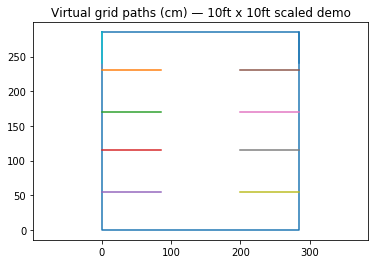

Drawing size: 285.0cm x 285.0cm (max allowed ~284.8cm)


In [7]:
plt.figure()
for poly in grid_paths_cm:
    plt.plot(poly[:,0], poly[:,1])
plt.title("Virtual grid paths (cm) — 10ft x 10ft scaled demo")
plt.axis("equal")
plt.show()

# Check final dimensions (should be <= DEMO_CM - 2*MARGIN_CM)
all_pts = np.vstack(grid_paths_cm)
width_cm = float(all_pts[:,0].max() - all_pts[:,0].min())
height_cm = float(all_pts[:,1].max() - all_pts[:,1].min())
print(f"Drawing size: {width_cm:.1f}cm x {height_cm:.1f}cm (max allowed ~{DEMO_CM - 2*MARGIN_CM:.1f}cm)")


In [8]:
def wrap_angle_deg(a):
    return (a + 180) % 360 - 180

def heading_deg(p0, p1):
    dx = float(p1[0] - p0[0])
    dy = float(p1[1] - p0[1])
    return math.degrees(math.atan2(dy, dx))

def dist_cm(p0, p1):
    return float(np.linalg.norm(p1 - p0))

def grid_paths_to_commands(grid_paths_cm, start_xy_cm=(0.0, 0.0), start_heading_deg=0.0):
    cmds = []
    current = np.array(start_xy_cm, dtype=float)
    heading = float(start_heading_deg)

    for poly in grid_paths_cm:
        start = poly[0]

        # travel move
        if np.linalg.norm(start - current) > 1e-6:
            tgt = heading_deg(current, start)
            turn = wrap_angle_deg(tgt - heading)
            drive = dist_cm(current, start)
            cmds.append(("PEN_UP", turn, drive))
            heading = tgt
            current = start.copy()

        # draw segments
        for i in range(len(poly) - 1):
            p0, p1 = poly[i], poly[i+1]
            if np.linalg.norm(p1 - p0) <= 1e-6:
                continue
            tgt = heading_deg(p0, p1)
            turn = wrap_angle_deg(tgt - heading)
            drive = dist_cm(p0, p1)
            cmds.append(("PEN_DOWN", turn, drive))
            heading = tgt
            current = p1.copy()

    return cmds

cmds = grid_paths_to_commands(grid_paths_cm, start_xy_cm=(0.0,0.0), start_heading_deg=0.0)
print("Total commands:", len(cmds))
print("First 10 commands:")
for c in cmds[:10]:
    print(c)


Total commands: 775
First 10 commands:
('PEN_UP', 90.0, 285.0)
('PEN_DOWN', -90.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)
('PEN_DOWN', 0.0, 2.5)


In [9]:
try:
    import easygopigo3 as easy
    gpg = easy.EasyGoPiGo3()
    servo2 = gpg.init_servo("SERVO2")
    print("GoPiGo connected.")
except Exception as e:
    print("GoPiGo not connected (SIMULATION mode). Reason:", e)
    gpg = None
    servo2 = None

# Calibrate these:
PEN_UP_ANGLE = 0
PEN_DOWN_ANGLE = 90

def pen_up():
    if servo2 is None:
        print("[SIM] PEN UP")
        return
    servo2.rotate_servo(PEN_UP_ANGLE)
    time.sleep(0.2)

def pen_down():
    if servo2 is None:
        print("[SIM] PEN DOWN")
        return
    servo2.rotate_servo(PEN_DOWN_ANGLE)
    time.sleep(0.2)


GoPiGo connected.


In [11]:
def turn_relative(deg):
    if gpg is None:
        print(f"[SIM] turn {deg:.2f} deg")
        return
    gpg.turn_degrees(deg)

def drive_cm(dist):
    if gpg is None:
        print(f"[SIM] drive {dist:.2f} cm")
        return
    gpg.drive_cm(dist)

def execute_commands(cmds, settle_s=0.05):
    for pen_state, turn_deg, drive_dist in cmds:
        if pen_state == "PEN_UP":
            pen_up()
        else:
            pen_down()

        if abs(turn_deg) > 1e-3:
            turn_relative(turn_deg)
        if drive_dist > 1e-3:
            drive_cm(drive_dist)

        time.sleep(settle_s)

    pen_up()
    print("Done.")

# WARNING: If GoPiGo is connected, this will move the robot.
execute_commands(cmds, settle_s=0.05)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1a022198a6c6>", line 31, in <module>
    execute_commands(cmds, settle_s=0.05)
  File "<ipython-input-11-1a022198a6c6>", line 18, in execute_commands
    pen_down()
  File "<ipython-input-10-02370d8b8f46>", line 27, in pen_down
    time.sleep(0.2)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.6/site-packages/IPython/core/u

KeyboardInterrupt: 